# Progetto Tesi Calciatori Under 21

## Importazione librerie

In [2]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from request_get import *
from utility import adf_test,get_all_teams,grangers_causation_matrix
from datetime import datetime
from dateutil import relativedelta
import statsmodels.api as sm
from scipy.stats import f_oneway,kstest,spearmanr,pearsonr,kendalltau
from scipy import stats
import numpy as np
import ruptures as rpt
import Rbeast as rb
import pymannkendall as mk
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.simplefilter('ignore', InterpolationWarning)


In [3]:
naz_under21=pd.read_excel("Punti_Nazionale_Under21.xlsx")
naz_under21=naz_under21.iloc[::-1]
naz_under21=naz_under21[10:-1]
naz_under21=naz_under21[["Anno","Punti per partita","Europeo"]]
naz_under21["Points_naz_u21"]=naz_under21["Punti per partita"]+naz_under21["Europeo"]

naz_under21.drop(["Europeo","Punti per partita"],axis=1,inplace=True)
naz_under21=naz_under21.set_index('Anno')
naz_under21.index.name = None

In [4]:
italy_ranking = pd.DataFrame()
for i in range(1992, 2023):
    df_temp = pd.read_excel('Ranking_Italy.xlsx', sheet_name=str(i))
    mean= df_temp['Total Points'].mean()
    df_temp = df_temp[df_temp['Team'] == 'Italy']
    df_temp['Year'] = i
    df_temp['Points'] = df_temp['Total Points']/mean
    italy_ranking = pd.concat([italy_ranking, df_temp], ignore_index=True)
italy_ranking = italy_ranking[['Year', 'RK','Total Points','Points']]
italy_ranking['Year'] = italy_ranking['Year'].astype(int)
italy_ranking['RK'] = italy_ranking['RK'].astype(int)
italy_ranking['Points'] = (italy_ranking['Points']+(1/italy_ranking['RK'])).astype(float)
#italy_ranking["Points"][14:17]=italy_ranking["Points"][14:17]-0.55
#italy_ranking["Points"][15:16]=italy_ranking["Points"][15:16]-0.2
italy_ranking=italy_ranking[['Year','Points']]
italy_ranking=italy_ranking.set_index('Year')
italy_ranking.index.name = None
italy_ranking.rename(columns={'Points':'Fifa_points'}, inplace=True)
italy_ranking.head()

,Fifa_points
1992,1.856497
1993,1.623797
1994,1.823655
1995,1.367495
1996,1.404581


In [5]:
#get_table_result()

In [6]:
dataset=pd.read_excel("ITACPI.xls")
valori_01_12 = dataset[dataset['date'].dt.month == 12]
valori_01_12.set_index(valori_01_12['date'].dt.year,inplace=True)
valori_01_12.drop(["date"],axis=1,inplace=True)
valori_01_12.index.name = None
valori_01_12=valori_01_12[7:]
valori_01_12[23:40]=valori_01_12[23:40]-18


In [7]:
dataframe=pd.DataFrame()
for i in range(1993,2022):
    data=pd.read_csv(f"data/{i}/serie-a.csv")
    #show the possible value on column movement
    data=data[data['movement']=='out']
    data=data[data['age']<=23]
    data["fee"].sum()
    #add the data to the dataframe on the column fee
    dataframe.loc[i,"fee"]=data["fee"].sum()
dataframe[-1:]=dataframe[-1:]+22262500
dataframe.loc[2022,"fee"]=58262500

In [8]:
dataframe=dataframe/1000000
dataframe=dataframe.join(valori_01_12,how="inner")      
dataframe["fee"]=dataframe["fee"]/dataframe["ITACPI"]*100
dataframe["revenue"]=np.log(dataframe["fee"])

In [9]:
adf_test(dataframe)

,fee,ITACPI,revenue
Test statistic,-2.2512,-0.2334,-2.9478
p-value,0.1882,0.9344,0.0401
Critical value - 1%,-3.7239,-3.6791,-3.6791
Critical value - 5%,-2.9865,-2.9679,-2.9679
Critical value - 10%,-2.6328,-2.6232,-2.6232


In [10]:
dataframe.drop(["fee","ITACPI"],axis=1,inplace=True)

In [11]:
from statsmodels.tsa.stattools import kpss
kpss(dataframe["revenue"],regression='c',nlags="legacy")

(0.4033622230333512,
 0.07570593834769346,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Importazione dataset

In [12]:
# le funzioni che seguono servono a prendere i dati da fbref e transfermarkt e salvarli in un file xlsx (definite nel file request_get.py)
#get_fbref()
#get_transfermarkt(2022,56)

In [13]:
#uefa_ranking=get_uefa_ranking()
#uefa_ranking=uefa_ranking[3:]


## Estrazione minuti di gioco

In [14]:
# Calcola i minuti giocati dai giocatori under 21 per ogni anno, stabilendo come under 21 i giocatori nati dopo il 1 Agosto 
all_teams=get_all_teams()
mesi = {
    "gen": 1, "feb": 2, "mar": 3, "apr": 4, "mag": 5, "giu": 6, "lug": 7, "ago": 8, "set": 9, "ott": 10, "nov": 11, "dic": 12
}
mins_played=pd.DataFrame(columns=["Minutes_played_under21","Minutes_played_italians","Minutes_played_foreigners","Minutes_played_oriundi"])
current_year = 2022
year_to_subtract = 56

for i in range(year_to_subtract):
    # Calculate the year to use in the URL
    year_url = f"{current_year - i}-{current_year + 1 - i}"
    players_tm=pd.read_excel(f"transfermarkt\SerieA{year_url}-Under21.xlsx")
    for j in range(len(players_tm)):
        parti = players_tm.loc[j,"Nato"].split('/')
        giorno_nasc = int(parti[0])
        mese_nasc = mesi[parti[1].lower()]  # Mappa il mese in minuscolo
        anno_nasc = int(parti[2])
        data_nasc = datetime(anno_nasc, mese_nasc, giorno_nasc)
        players_tm.loc[j,"Data di nascita"]=data_nasc
        data_inizio=datetime(current_year-i, 1, 1)
        anni=relativedelta.relativedelta(data_inizio, data_nasc).years
        players_tm.loc[j,"Anni"]=anni
    
    under=players_tm[players_tm["Anni"]<21]
    under_italia=under[under["Nazione"]=="Italia"]
    under_stranieri= under[~under["Nazione"].str.contains(r'\b^Italia$\b|^Italia/\b', case=False, na=False)]
    under_oriundi = under[under["Nazione"].str.contains(r'^Italia/\b', case=False, na=False)]
    mins_played.loc[year_url,"Minutes_played_italians"]=under_italia["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minutes_played_under21"]=under["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minutes_played_foreigners"]=under_stranieri["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minutes_played_oriundi"]=under_oriundi["Minuti giocati"].sum()
   
    # count the minutes played for each team
    team_minutes=players_tm[["Squadra","Minuti giocati"]].groupby("Squadra").sum().sort_values(by="Minuti giocati",ascending=False).transpose()
    #set the index of the dataframe
    team_minutes.columns.name = None
    team_minutes=team_minutes.reset_index(drop=True)
    team_minutes["Anno"]=year_url
    team_minutes=team_minutes.set_index('Anno')
    team_minutes.index.name = None
    all_teams.loc[year_url] = team_minutes.loc[year_url]

### Normalizzazione minuti di gioco

In [15]:
"""normalize Minuti giocati to total minutes played in the league and create another column
(from 2022-2023 to 2004-2005 divided for 3420 minutes,
from 2003-2004 to 1988-1989 divided for 3060 minutes
from 1987-1988 to 1968-1969 divided for 2700 minutes)"""

mins_played=mins_played.iloc[::-1]
#1967, cioè -56
mins_played[0:21]=mins_played[0:21]/(90*11*30*20)*100
mins_played[21:37]=mins_played[21:37]/(90*11*34*20)*100
mins_played[37:]=mins_played[37:]/(90*11*38*20)*100

mins_played["Minutes_played_under21"]=mins_played["Minutes_played_under21"].astype(float)
mins_played["Minutes_played_italians"]=mins_played["Minutes_played_italians"].astype(float)
mins_played["Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"].astype(float)
mins_played["Minutes_played_oriundi"]=mins_played["Minutes_played_oriundi"].astype(float)

In [16]:
#!!!!!!join the dataframe mins_played with uefa_ranking and italy_ranking!!!!!!!!
mins_played.index=mins_played.index.str[:4].astype(int)
mins_played=mins_played.join(italy_ranking,how='outer')
mins_played=mins_played.join(naz_under21,how='outer')
mins_played=mins_played.join(dataframe,how='outer')

In [17]:
mins_played.head()

,Minutes_played_under21,Minutes_played_italians,Minutes_played_foreigners,Minutes_played_oriundi,Fifa_points,Points_naz_u21,revenue
1967,6.639057,6.639057,0.0,0.000000,NaN,NaN,NaN
1968,4.841582,4.826431,0.0,0.015152,NaN,NaN,NaN
1969,6.224579,6.224579,0.0,0.000000,NaN,NaN,NaN
1970,5.095960,5.095960,0.0,0.000000,NaN,NaN,NaN
1971,6.866667,6.859091,0.0,0.007576,NaN,NaN,NaN


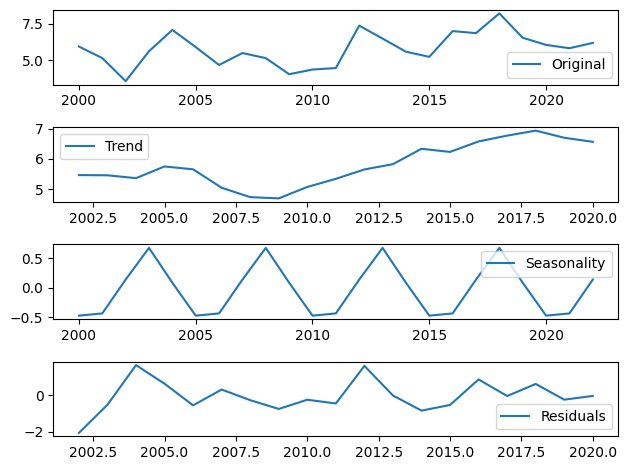

In [18]:
#seasonal decomposition of the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mins_played["Minutes_played_under21"][33:], period=5)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(mins_played["Minutes_played_under21"][33:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [19]:
#calculate the variance of the trend
import statistics
strenght=1-(statistics.variance(trend.dropna())/(statistics.variance(trend.dropna())+statistics.variance(residual.dropna())))
#statistics.variance(trend.dropna())
print("Variance of trend : % s " % strenght)


Variance of trend : 0.6038815921445959 


## Grafici

In [20]:
top_teams=all_teams.iloc[::-1]
top_teams=all_teams[35:]
#select the column with max 5 NAN values
top_teams=top_teams.loc[:,top_teams.isnull().sum() < 12]
top_teams.fillna(0,inplace=True)
top_teams=top_teams.astype(float)


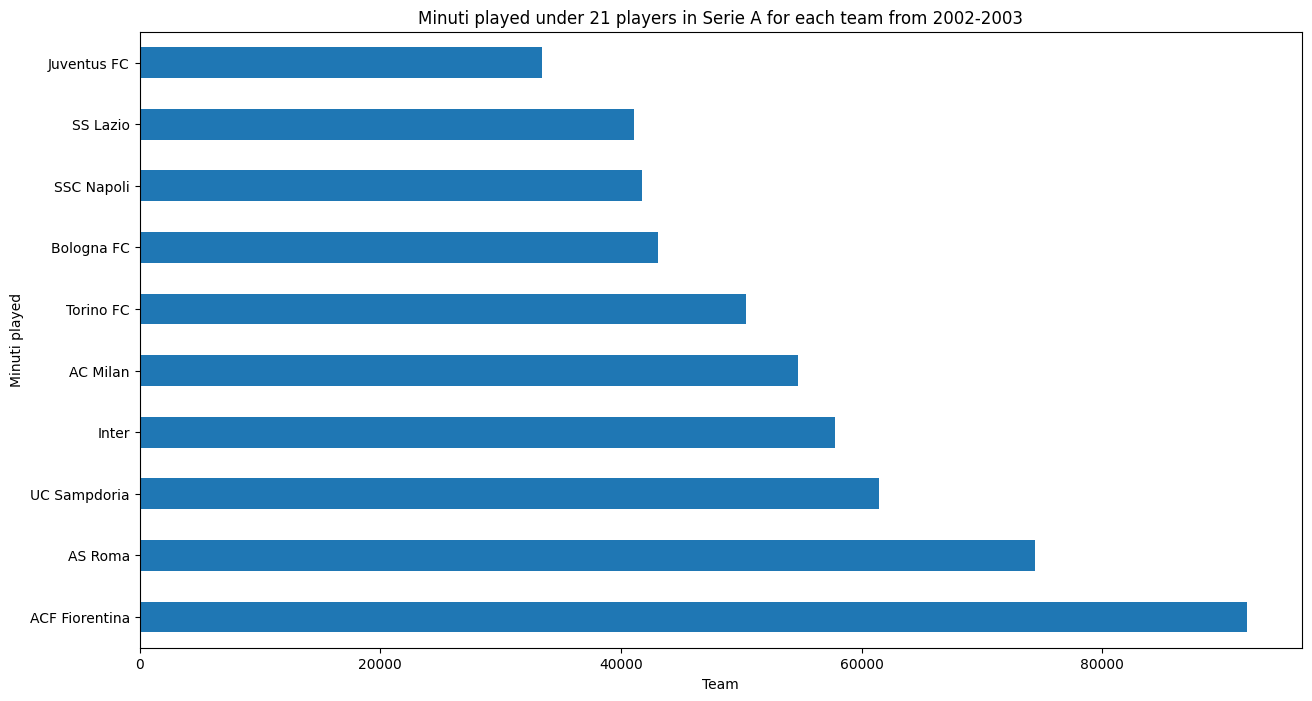

In [21]:
#create a histogram with the minutes played by each team o the dataset
top_teams.sum().sort_values(ascending=False)[:-2].plot(kind='barh',figsize=(15,8))
plt.title("Minuti played under 21 players in Serie A for each team from 2002-2003")
plt.ylabel("Minuti played")
plt.xlabel("Team")
plt.show()

In [22]:
#esegue la media dei minuti giocati normalizzati ogni 8 stagioni
mins_played_10=pd.DataFrame(columns=["Minutes_played_under21"])
mins_played_10.loc["1969-1976","Minutes_played_under21"]=mins_played["Minutes_played_under21"][0:8].mean()
mins_played_10.loc["1977-1984","Minutes_played_under21"]=mins_played["Minutes_played_under21"][8:16].mean()
mins_played_10.loc["1985-1992","Minutes_played_under21"]=mins_played["Minutes_played_under21"][16:24].mean()
mins_played_10.loc["1993-2000","Minutes_played_under21"]=mins_played["Minutes_played_under21"][24:32].mean()
mins_played_10.loc["2001-2008","Minutes_played_under21"]=mins_played["Minutes_played_under21"][32:40].mean()
mins_played_10.loc["2009-2017","Minutes_played_under21"]=mins_played["Minutes_played_under21"][40:48].mean()
mins_played_10.loc["2017-2022","Minutes_played_under21"]=mins_played["Minutes_played_under21"][48:].mean()

mins_played_10.loc["1969-1976","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][0:8]+mins_played["Minutes_played_oriundi"][0:8]).mean()
mins_played_10.loc["1977-1984","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][8:16]+mins_played["Minutes_played_oriundi"][8:16]).mean()
mins_played_10.loc["1985-1992","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][16:24]+mins_played["Minutes_played_oriundi"][16:24]).mean()
mins_played_10.loc["1993-2000","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][24:32]+mins_played["Minutes_played_oriundi"][24:32]).mean()
mins_played_10.loc["2001-2008","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][32:40]+mins_played["Minutes_played_oriundi"][32:40]).mean()
mins_played_10.loc["2009-2017","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][40:48]+mins_played["Minutes_played_oriundi"][40:48]).mean()
mins_played_10.loc["2017-2022","Minutes_played_italians"]=(mins_played["Minutes_played_italians"][48:]+mins_played["Minutes_played_oriundi"][48:]).mean()


mins_played_10.loc["1969-1976","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][0:8].mean()
mins_played_10.loc["1977-1984","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][8:16].mean()
mins_played_10.loc["1985-1992","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][16:24].mean()
mins_played_10.loc["1993-2000","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][24:32].mean()
mins_played_10.loc["2001-2008","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][32:40].mean()
mins_played_10.loc["2009-2017","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][40:48].mean()
mins_played_10.loc["2017-2022","Minutes_played_foreigners"]=mins_played["Minutes_played_foreigners"][48:].mean()

#mins_played_10.head(8)

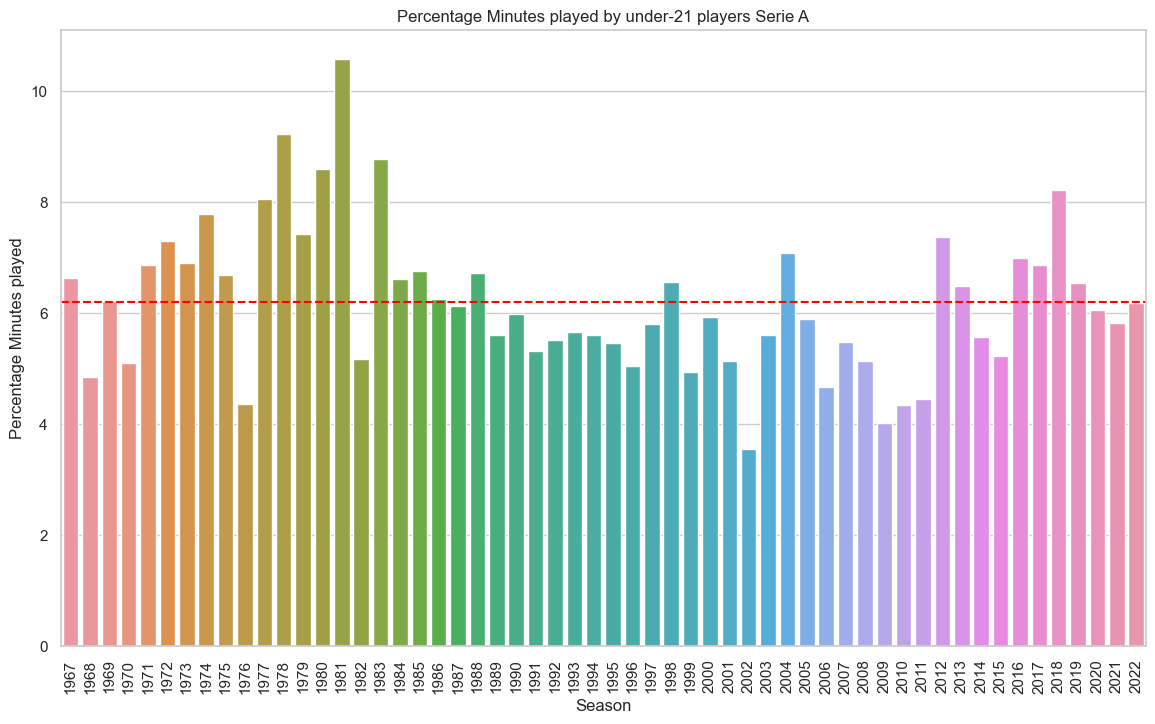

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14,8))
sns.barplot(x=mins_played.index, y=mins_played["Minutes_played_under21"])
plt.xticks(rotation=90)
plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Percentage Minutes played by under-21 players Serie A")
#print line mean
plt.axhline(mins_played["Minutes_played_under21"].mean(), color='red', linestyle='--')

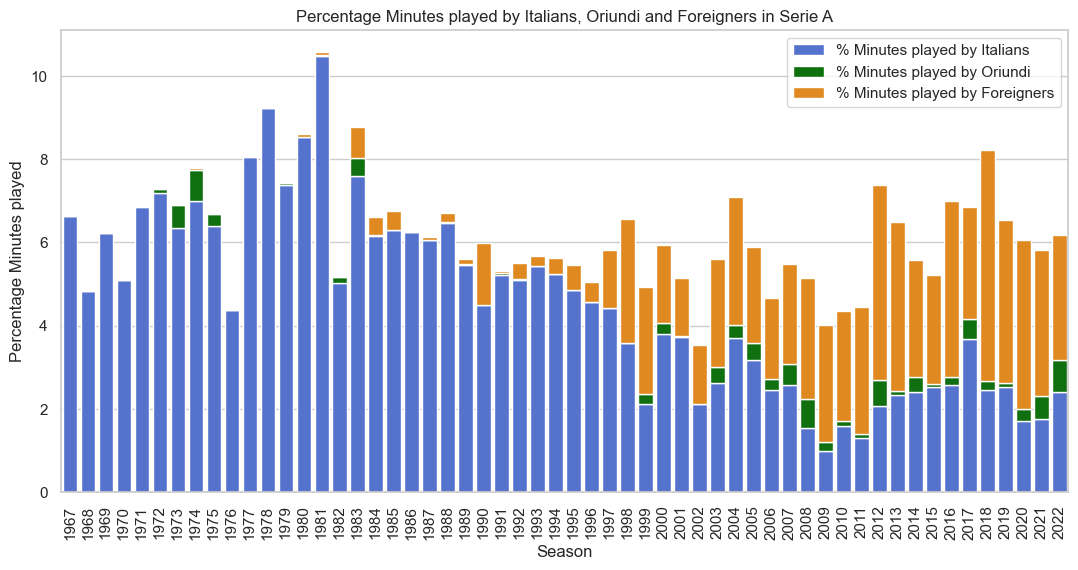

In [24]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(13, 6))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minutes_played_italians", color="royalblue",label="% Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minutes_played_oriundi",color="green",label="% Minutes played by Oriundi", bottom=mins_played["Minutes_played_italians"])
sns.barplot(data=mins_played, x=mins_played.index, y="Minutes_played_foreigners",color="darkorange",label="% Minutes played by Foreigners", bottom=mins_played["Minutes_played_italians"] + mins_played["Minutes_played_oriundi"])



# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians, Oriundi and Foreigners in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

Text(0.5, 1.0, 'Percentual minutes played by Under 21 players every 8 seasons')

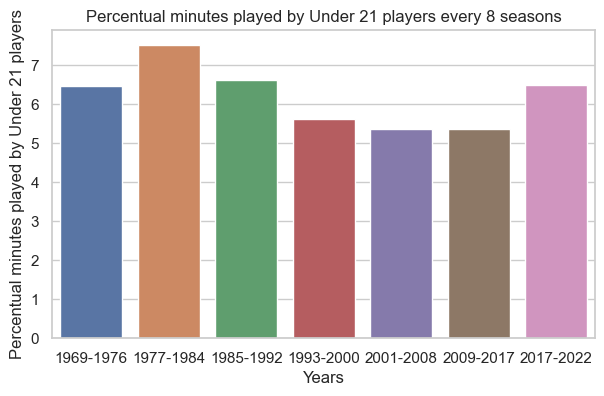

In [25]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,4))
#plto two column of barplot for the percentage of minutes played by under 21 italians players and for the percentage of minutes played by under 21 foreigner players

sns.barplot(x=mins_played_10.index, y=mins_played_10["Minutes_played_under21"])


plt.xlabel("Years")
plt.ylabel("Percentual minutes played by Under 21 players")
plt.title("Percentual minutes played by Under 21 players every 8 seasons")

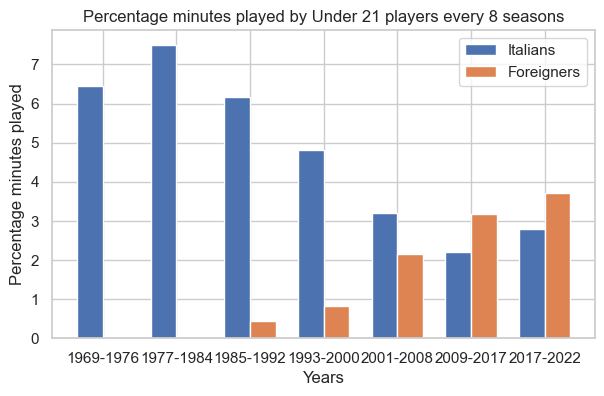

In [26]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7,4))
larghezza_barre = 0.35
barre_italiani = np.arange(len(mins_played_10.index))
barre_stranieri = [x + larghezza_barre for x in barre_italiani]

# Creazione dell'istogramma
plt.bar(barre_italiani, mins_played_10["Minutes_played_italians"], width=larghezza_barre, label='Italians')
plt.bar(barre_stranieri, mins_played_10["Minutes_played_foreigners"],width=larghezza_barre,  label='Foreigners')

# Personalizzazione del grafico
plt.xlabel('Years')
plt.ylabel('Percentage minutes played')
plt.title('Percentage minutes played by Under 21 players every 8 seasons')
plt.xticks([r + larghezza_barre / 2 for r in range(len(mins_played_10.index))], mins_played_10.index)
plt.legend()

# Visualizzazione del grafico
plt.show()

### Nan

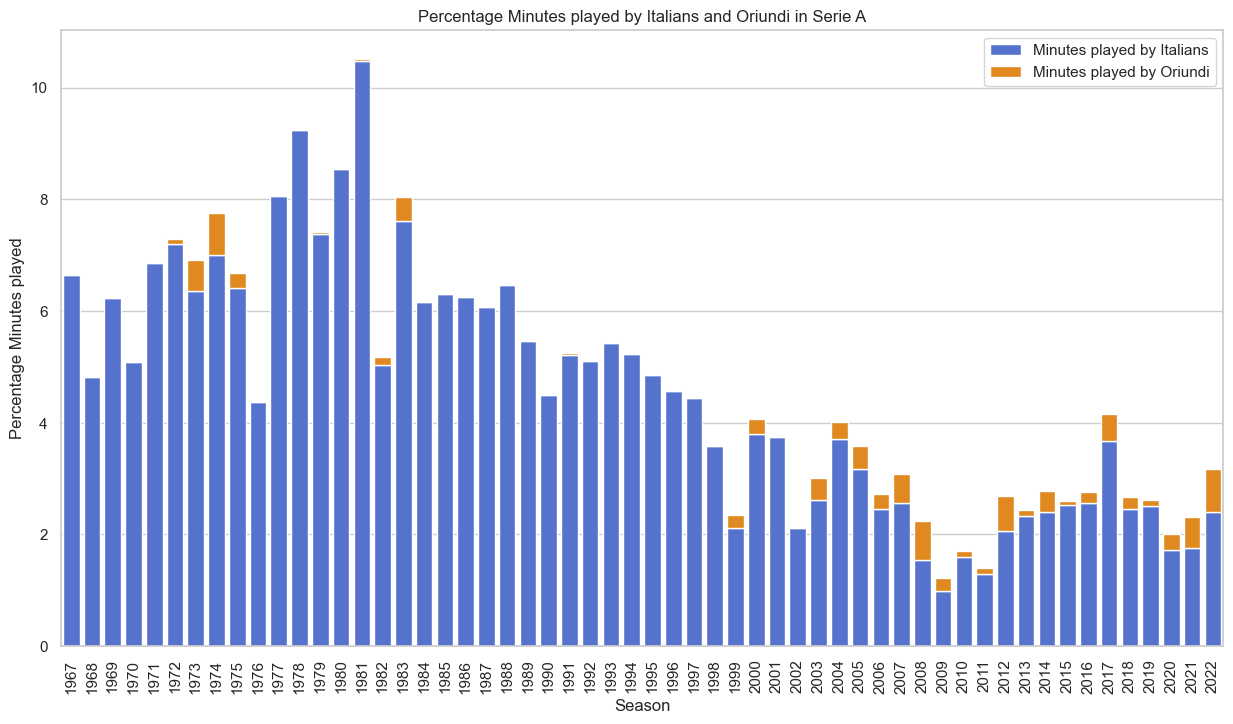

In [27]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minutes_played_italians", color="royalblue",label="Minutes played by Italians")
sns.barplot(data=mins_played, x=mins_played.index, y="Minutes_played_oriundi",color="darkorange",label="Minutes played by Oriundi", bottom=mins_played["Minutes_played_italians"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Season')
plt.ylabel('Percentage Minutes played') 
plt.title('Percentage Minutes played by Italians and Oriundi in Serie A')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

In [28]:
#convert index to datetime
mins_played.index=pd.to_datetime(mins_played.index,format='%Y')

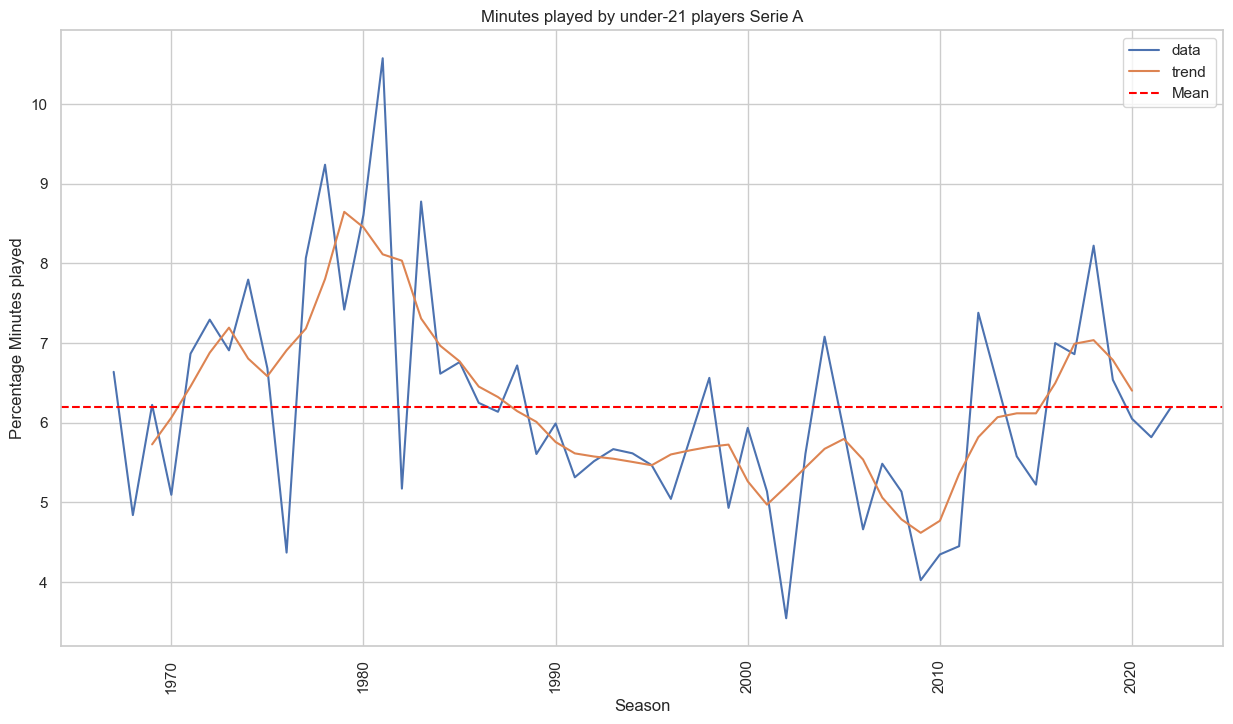

In [29]:
result = seasonal_decompose(mins_played["Minutes_played_under21"], model='additive',period=4)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
plt.plot(mins_played.index,mins_played["Minutes_played_under21"],label="data",linewidth=1.5)
plt.plot(mins_played.index,result.trend,label="trend")


plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Minutes played by under-21 players Serie A")
#rotate the x ticks



plt.xticks(rotation=90)
plt.axhline(mins_played["Minutes_played_under21"].mean(), color='red', linestyle='--',label="Mean")
plt.legend()
plt.show()

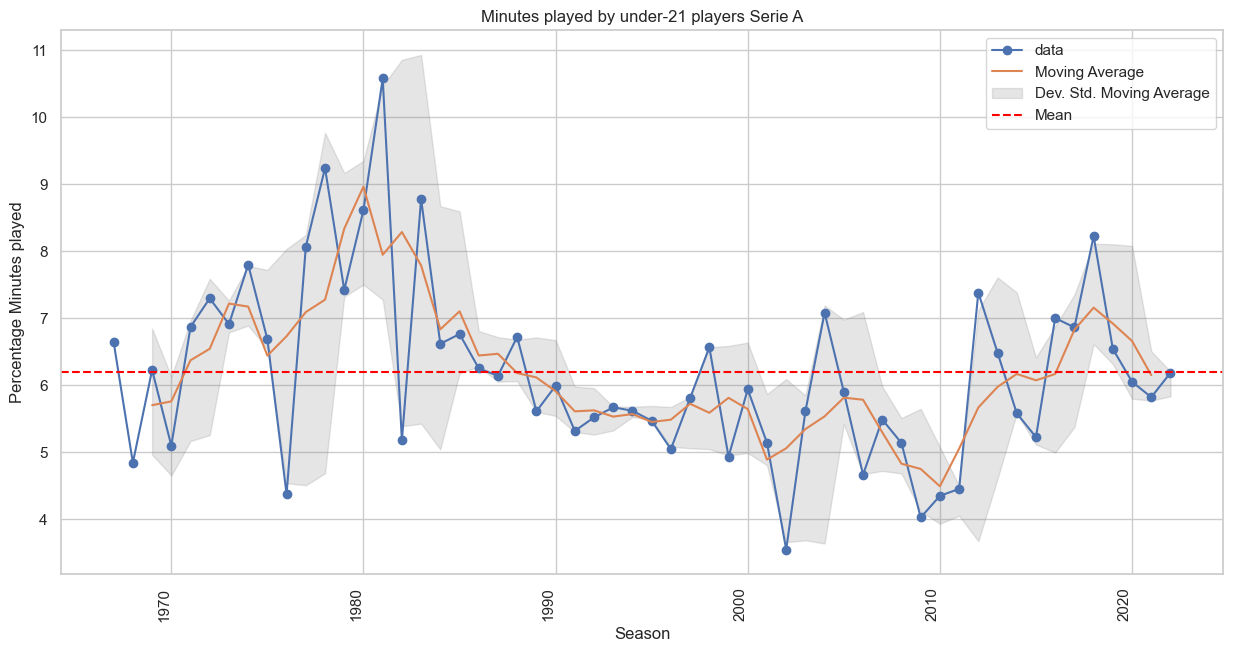

In [30]:
#print a line plot with the minutes played normalized with line mean and marker 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
plt.plot(mins_played.index,mins_played["Minutes_played_under21"],marker='o',label="data")

plt.xlabel("Season")
plt.ylabel("Percentage Minutes played")
plt.title("Minutes played by under-21 players Serie A")
#rotate the x ticks

mins_played["Minutes_played_under21"].rolling(4,center=True).mean().plot(label="Moving Average")
#stampa anche la rolling variance

plt.fill_between(mins_played.index, mins_played["Minutes_played_under21"].rolling(3).mean() - mins_played["Minutes_played_under21"].rolling(3).std(), mins_played["Minutes_played_under21"].rolling(3).mean() + mins_played["Minutes_played_under21"].rolling(3).std(), color='gray', alpha=0.2, label='Dev. Std. Moving Average')


plt.xticks(rotation=90)
plt.axhline(mins_played["Minutes_played_under21"].mean(), color='red', linestyle='--',label="Mean")
plt.legend()
plt.show()



## Bayesian changepoint detection con Rbeast

### Analisi changepoint under-21


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.000|*                                               |
|Pr(ncp = 1 )=0.000|*                                               |
|Pr(ncp = 2 )=0.277|*********************************               |
|Pr(ncp = 3 )=0.400|*********************************************** |
|Pr(ncp = 4 )=0.211|*****

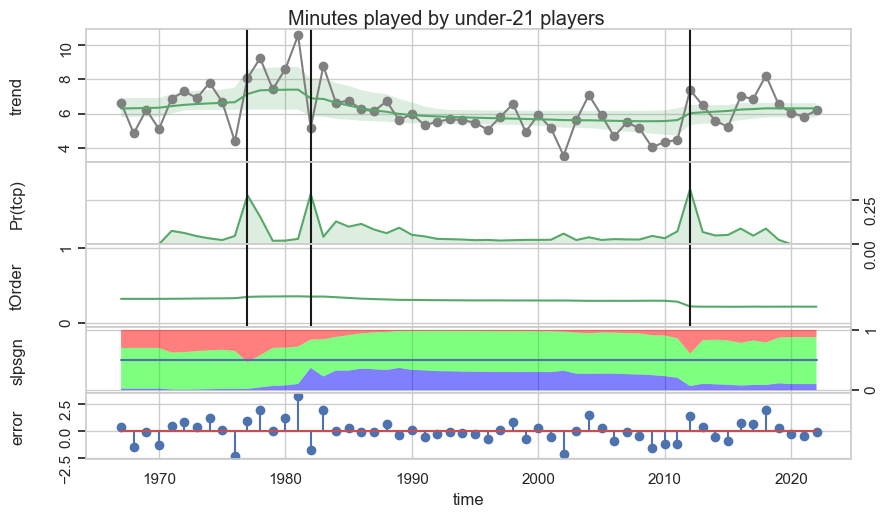

In [31]:
import numpy as np
plt.rcParams['figure.figsize'] = [9, 5]
o=rb.beast(mins_played['Minutes_played_under21'], start=1967, season='none',tcp_minmax=[2,6], print_options = False,print_progress=False)
rb.plot(o,title='Minutes played by under-21 players')
rb.print(o)

In [32]:
import numpy as np
o=rb.beast(mins_played['Minutes_played_under21'][0:32], start=1967, deltat=1,period="1.0 year",mcmc_seed=1,print_options = False,print_progress=False)
#rb.plot(o,title='Minutes played by under-21 players from 1967 to 2000')
#rb.print(o)

In [33]:
#Mann_Kendall_Test_Hamed_Rao_Approach 71/84
data = (mins_played["Minutes_played_under21"][3:17])

#fig, ax = plt.subplots(figsize=(8, 5))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 71-84:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept
#plt.xticks(rotation=90)
#ax.plot(data)
#ax.plot(data.index, trend_line)
#ax.legend(['data', 'trend line'])


Mann_Kendall_Test_Hamed_Rao_Approach 71-84:
Trend:  increasing
Z-Value:  1.9708160452248922
P-Value:  0.0487449207397066
Slope:  0.19350916573138793


In [34]:
data = (mins_played["Minutes_played_under21"][16:27])

#fig, ax = plt.subplots(figsize=(8, 5))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 83-93:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)
#print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept
#plt.xticks(rotation=90)
#ax.plot(data)
#ax.plot(data.index, trend_line)
#ax.legend(['data', 'trend line'])
#rottate the x ticks
#print hte result of Mann_Kendall_Test_Hamed_Rao_Approach 84-92 from res


Mann_Kendall_Test_Hamed_Rao_Approach 83-93:
Trend:  decreasing
Z-Value:  -2.8025961989814827
P-Value:  0.0050693095567015956
Slope:  -0.18324915824915822


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: xlabel='[]', ylabel='trend'>,
        <Axes: xlabel='[]', ylabel='Pr(tcp)'>,
        <Axes: xlabel='[]', ylabel='tOrder'>,
        <Axes: xlabel='[]', ylabel='slpsgn'>,
        <Axes: xlabel='time', ylabel='error'>], dtype=object))

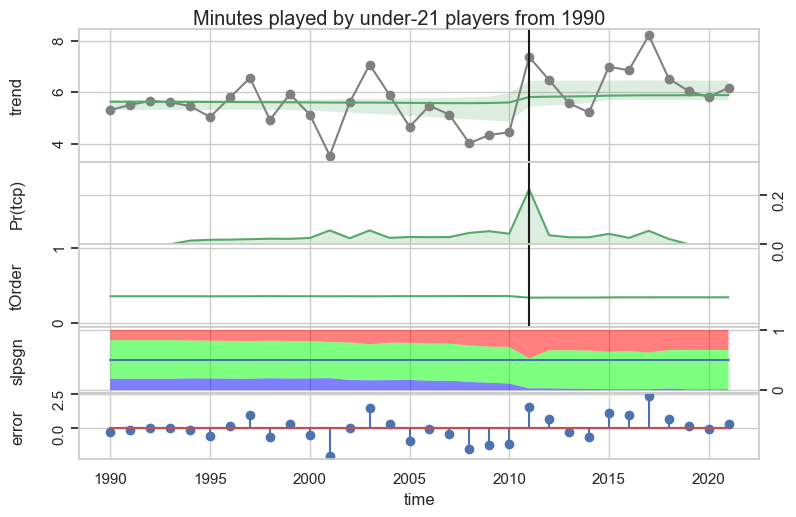

In [35]:
#Trend and changepoint in the number of minutes played by under-21 players from 1990
plt.rcParams['figure.figsize'] = [8, 5]
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minutes_played_under21'][24:], start=1990,season="none",print_options=False,print_progress=False)
rb.plot(o,title='Minutes played by under-21 players from 1990')
#rb.print(o)

In [36]:
data = (mins_played["Minutes_played_under21"][24:47])



#fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print("Mann_Kendall_Test_Hamed_Rao_Approach 1991-2011:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[:-2])
#ax.plot(data[:-2].index, trend_line[:-2])
#ax.legend(['data', 'trend line'])

Mann_Kendall_Test_Hamed_Rao_Approach 1991-2011:
Trend:  no trend
Z-Value:  -0.4225673021598867
P-Value:  0.6726109872286647
Slope:  -0.013080830418291698


In [37]:
#Applying ADCF test
#The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series.
from statsmodels.tsa.stattools import adfuller
# Crea due campioni di dati
# Esegui il test di Dickey-Fuller
result = adfuller(mins_played["Entrate"][27:-2].diff().dropna())
print('Statistiche ADF: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


KeyError: 'Entrate'

In [ ]:
#Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
from statsmodels.tsa.stattools import kpss

result = kpss(mins_played["Minutes_played_under21"][23:46])
print('\nStatistiche KPSS: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))



Statistiche KPSS: 0.214776
Valore p: 0.100000
Valori critici:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [ ]:
#make the Phillips–Perron (PP) Test
from arch.unitroot import PhillipsPerron
pp = PhillipsPerron(mins_played["Minutes_played_under21"][23:46])
print(pp.summary().as_text())


In [ ]:
data = (mins_played["Minutes_played_under21"][42:])

#fig, ax = plt.subplots(figsize=(8, 4))
res = mk.yue_wang_modification_test(data,alpha=0.05)

print("Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)

#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data)
#ax.plot(data.index, trend_line)
#plt.xticks(rotation=90)
#ax.legend(['data', 'trend line'])

### Analisi changepoint italiani under-21

In [ ]:
import Rbeast as rb
import numpy as np
plt.rcParams['figure.figsize'] = [9, 5]
sns.set_theme(style="white")
o=rb.beast((mins_played['Minutes_played_italians'] +mins_played['Minutes_played_oriundi'] ), start=1967, deltat=1,period="1.0 year",print_options = False,print_progress=False)
rb.plot(o,title='Minutes played by Italians under-21 players')
rb.print(o)

In [ ]:
mins_played['Minutes_played_italians'][45:46]=3.2

In [ ]:
import Rbeast as rb
import numpy as np
plt.rcParams['figure.figsize'] = [8, 5]

o=rb.beast((mins_played['Minutes_played_italians'][23:]), start=1990, deltat=1,period="1.0 year",print_options=False,print_progress=False)
rb.plot(o,title='Minutes played by Italians under-21 players from 1990',ncpStat="mean")
rb.print(o)


In [ ]:
data = (mins_played["Minutes_played_italians"][41:] + mins_played["Minutes_played_oriundi"][41:])

#fig, ax = plt.subplots(figsize=(6, 4))
res = mk.hamed_rao_modification_test(data,alpha=0.075)
print("Mann_Kendall_Test_Hamed_Rao_Approach 2009-2022 italian player:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p-0.029)
print("Slope: ",res.slope)


#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[1:])
#ax.plot(data[1:].index, trend_line[1:])
#ax.legend(['data', 'trend line'])

In [ ]:
data = (mins_played["Minutes_played_italians"][25:41] + mins_played["Minutes_played_oriundi"][25:41])

#fig, ax = plt.subplots(figsize=(12, 8))
res = mk.original_test(data,alpha=0.05)
print("Mann_Kendall_Test_Hamed_Rao_Approach 1993-2006 italian player:")
print("Trend: ",res.trend)
print("Z-Value: ",res.z)
print("P-Value: ",res.p)
print("Slope: ",res.slope)
#print(res)
#trend_line = np.arange(len(data)) * res.slope + res.intercept

#ax.plot(data[1:])
#ax.plot(data[1:].index, trend_line[1:])
#ax.legend(['data', 'trend line'])

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
test_obs = 5
train = mins_played[["Fifa_points","Minutes_played_italians"]][29:-1]
test = mins_played[["Fifa_points","Minutes_played_italians"]][-5:]



In [ ]:
test

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()


In [ ]:
model_fitted = model.fit(4)
model_fitted.summary()

In [ ]:
mins_played.tail()

In [ ]:
mins_played["Points_naz_u21"][26:].plot()
mins_played["Minutes_played_italians"][26:].plot()

In [ ]:
mins_played["Minutes_played_under21"].tail(20)

In [ ]:
(mins_played["Saldo"][34:]).plot()
mins_played["Minutes_played_under21"][34:].plot(color="red")

In [ ]:
mins_played.corr("spearman")

In [ ]:

from arch.unitroot import ADF

ADF(mins_played[["Minutes_played_under21"]][25:].diff().dropna(), trend="n")

In [ ]:
adf_test(mins_played[["Fifa_points"]][29:])

In [ ]:
from statsmodels.tsa.stattools import coint
coint(mins_played["Minutes_played_under21"][25:],mins_played["Fifa_points"][25:],return_results=True)


In [ ]:
from arch.unitroot import engle_granger

eg_test = engle_granger(mins_played[["Points_naz_u21"]][24:],mins_played[["Minutes_played_italians"]][24:], trend="c")
eg_test

In [ ]:
from statsmodels.tsa.stattools import coint
coint(np.log(mins_played["Entrate"][26:-4]),mins_played["Minutes_played_under21"][26:-4],return_results=True)

In [ ]:
from arch.unitroot import engle_granger

eg_test = engle_granger(mins_played["Entrate"][26:-4],mins_played["Minutes_played_under21"][26:-4], trend="c")
eg_test


In [ ]:

from arch.unitroot import engle_granger

eg_test = engle_granger(mins_played[["Uefa_Ranking"]][24:],mins_played[["Minutes_played_under21"]][24:], trend="c")
eg_test

In [ ]:
from arch.unitroot.cointegration import phillips_ouliaris

po_zt_test = phillips_ouliaris(mins_played[["Points_naz_u21"]][25:],mins_played[["Minutes_played_italians"]][25:], trend="n", test_type="Zt")
po_zt_test.summary()

In [ ]:
mins_played["Anno"]=mins_played.index

In [ ]:
#stampa il grafico della correlazione tra i minuti giocati dai giocatori under 21 e il ranking uefa come retta di regressione
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.regplot(x=mins_played["Anno"][40:], y=mins_played["Minutes_played_under21"][40:])
plt.xlabel("Minutes_played_under21")
plt.ylabel("Uefa_Ranking")
plt.title("Correlazione tra i minuti giocati dai giocatori under 21 e il ranking uefa")
plt.show()


In [ ]:
#fai la OLS regression con x l'indice e y i minuti giocati dai giocatori under 21
#fai la OLS regression tra i minuti giocati dai giocatori under 21 e il ranking uefa
import statsmodels.api as sm

X = mins_played[["Minutes_played_italians"]][24:]
y = mins_played[["Points_naz_u21"]][24:]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


In [ ]:
#fai la OLS regression con x l'indice e y i minuti giocati dai giocatori under 21
#fai la OLS regression tra i minuti giocati dai giocatori under 21 e il ranking uefa
import statsmodels.api as sm

X = mins_played[["Minutes_played_under21"]][32:]
y = mins_played[["Entrate"]][32:]
X = sm.add_constant(X)
model = sm.OLS(y, X)    
results = model.fit()
print(results.summary())

In [ ]:
#implemetna lasso e ridge regression per la regressione tra i minuti giocati dai giocatori under 21 e il ranking uefa
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

X = mins_played[["Minutes_played_under21"]][32:]
y = mins_played[["Entrate"]][32:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
model = LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("R2 score: ",r2_score(y_test,y_pred))
print("MSE: ",mean_squared_error(y_test,y_pred))

model = Ridge(alpha=0.1)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("R2 score: ",r2_score(y_test,y_pred))
print("MSE: ",mean_squared_error(y_test,y_pred))

model = Lasso(alpha=0.1)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("R2 score: ",r2_score(y_test,y_pred))
print("MSE: ",mean_squared_error(y_test,y_pred))




In [ ]:
#stampa il grafico della correlazione tra i minuti giocati dai giocatori under 21 e il ranking uefa come retta di regressione
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.regplot(x = mins_played[["Minutes_played_under21"]][34:], y = mins_played[["Entrate"]][34:])
plt.xlabel("Minutes_played_under21")
plt.ylabel("Entrate")
plt.title("Correlazione tra i minuti giocati dai giocatori under 21 e le entrate")
plt.show()


In [ ]:
# Import packages
import numpy as np
from scipy.stats import linregress

# Generate time series
A = [2, 4, 6, 8, 10, 8, 8, 12, 14, 18, 18, 20, 16, 18, 20, 14, 14, 16, 20]
B = [2, 3, 7, 9, 11, 9, 10, 11, 12, 15, 17, 19, 15, 16, 21, 12, 12, 17, 22]

# Calculate regression line
print(linregress(mins_played["Minutes_played_italians"][30:], mins_played["Fifa_points"][30:]))
#print(linregress(mins_played["Minutes_played_under21"][34:],mins_played["Entrate"][34:]))

#fai la OLS regression tra i minuti giocati dai giocatori under 21 e il ranking uefa
import statsmodels.api as sm

X = mins_played["Minutes_played_italians"][29:-1]
y = mins_played["Points_naz_u21"][29:-1]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
#print(results.summary())
# Import packages

In [ ]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))
        

# Carry out ADF test 0.2114620561042145
#residuals = mins_played["Points_naz_u21"][25:] - 0.3013333608628585 * mins_played["Minutes_played_italians"][25:]
residuals = mins_played["Fifa_points"][30:] - 0.07756339481258104 * mins_played["Minutes_played_italians"][30:]

#residuals = mins_played["Entrate"][34:] - 104.17116676309917 * mins_played["Minutes_played_under21"][34:]

adf_test(residuals)

In [ ]:
mins_played["Minutes_played_italians"][25:].plot(color="red")
mins_played["Points_naz_u21"][25:].plot()

In [ ]:
mins_played.corr()

In [ ]:
#fai la OLS regression tra i minuti giocati dai giocatori under 21 e il ranking uefa
import statsmodels.api as sm

X = mins_played[["Minutes_played_italians"]] 
y = mins_played[["Num_Giocatori_Italiani"]]/10
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


### Autocorrelazione

In [ ]:
#test durbin watson per determinare autocorrelazione nei residui del modello di regressione lineare
#Il valore della statistica di Durbin-Watson è sempre compreso tra 0 e 4.
#Un valore di 2 indica che non appare presente alcuna autocorrelazione. Valori piccoli di d indicano che i residui successivi sono, in media, vicini in valore l'uno all'altro, o correlati positivamente.
#Valori grandi di d indicano che i residui successivi sono, in media, molto differenti in valore l'uno dall'altro, o correlati negativamente.

# Fit a linear regression model (you can replace this with your specific model)
model_ita = sm.OLS((mins_played['Minutes_played_italians'][42:]+mins_played['Minutes_played_oriundi'][42:]), np.arange(len(mins_played['Minutes_played_italians'][42:]))).fit()
model_2012= sm.OLS(mins_played['Minutes_played_under21'][42:], np.arange(len(mins_played['Minutes_played_under21'][42:]))).fit()
model_1977= sm.OLS(mins_played['Minutes_played_under21'][3:17], np.arange(len(mins_played['Minutes_played_under21'][3:17]))).fit()
model_1984= sm.OLS(mins_played['Minutes_played_under21'][17:26], np.arange(len(mins_played['Minutes_played_under21'][17:26]))).fit()
model_1993= sm.OLS(mins_played['Minutes_played_under21'][25:46], np.arange(len(mins_played['Minutes_played_under21'][25:46]))).fit()
# Calculate Durbin-Watson statistic
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model_ita.resid)
durbin_watson_statistic2012 = sm.stats.stattools.durbin_watson(model_2012.resid)
durbin_watson_statistic1977 = sm.stats.stattools.durbin_watson(model_1977.resid)
durbin_watson_statistic1984 = sm.stats.stattools.durbin_watson(model_1984.resid)
durbin_watson_statistic1993 = sm.stats.stattools.durbin_watson(model_1993.resid)

print(f'Durbin-Watson Statistic 2009/2022 ita: {durbin_watson_statistic}')
print(f'Durbin-Watson Statistic 2009/2022: {durbin_watson_statistic2012}')
print(f'Durbin-Watson Statistic 1971/1983: {durbin_watson_statistic1977}')
print(f'Durbin-Watson Statistic 1984/1993: {durbin_watson_statistic1984}')
print(f'Durbin-Watson Statistic 1993/2011: {durbin_watson_statistic1993}')



In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf((mins_played['Minutes_played_italians'][39:]+mins_played['Minutes_played_oriundi'][39:]), lags=14, ax=ax)
#print only one plot
plt.show()

In [ ]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(mins_played["Minutes_played_under21"][39:], lags=14, ax=ax)
plt.show()

In [ ]:
mean_74_84=mins_played["Minutes_played_under21"][10:18].mean()
print(f"Media dal 1974 al 1984 : {mean_74_84}")
print(f"Deviazione standard dal 1974 al 1984 : {mins_played['Minutes_played_under21'][10:18].std()}")
#varianza
print(f"Varianza dal 1974 al 1984 : {mins_played['Minutes_played_under21'][11:18].var()}")
#Errore Standard della Media (SEM): è la deviazione standard della distribuzione delle medie campionarie.
print(f"SEM dal 1974 al 1984 : {mins_played['Minutes_played_under21'][10:18].std()/np.sqrt(len(mins_played['Minutes_played_under21'][6:18]))}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_first = stats.t.interval(0.95, len(mins_played["Minutes_played_under21"][10:18])-1, loc=mean_74_84, scale=stats.sem(mins_played["Minutes_played_under21"][10:18]))
confidence_interval_first_90 = stats.t.interval(0.90, len(mins_played["Minutes_played_under21"][10:18])-1, loc=mean_74_84, scale=stats.sem(mins_played["Minutes_played_under21"][10:18]))
print(f"Intervallo di Confidenza al 95% dal 1974 al 1984: {confidence_interval_first}")
print(f"Intervallo di Confidenza al 90% dal 1974 al 1984: {confidence_interval_first_90}")

mean_85_2011=mins_played["Minutes_played_under21"][20:45].mean()
print(f"Media dal 1985 al 2011 : {mean_85_2011}")
print(f"Varianza dal 1985 al 2011 : {mins_played['Minutes_played_under21'][20:45].var()}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_second = stats.t.interval(0.95, len(mins_played["Minutes_played_under21"][20:45])-1, loc=mean_85_2011, scale=stats.sem(mins_played["Minutes_played_under21"][20:45]))
confidence_interval_second_90 = stats.t.interval(0.90, len(mins_played["Minutes_played_under21"][20:45])-1, loc=mean_85_2011, scale=stats.sem(mins_played["Minutes_played_under21"][20:45]))
print(f"Intervallo di Confidenza al 95% dal 1985 al 2011: {confidence_interval_second}")
print(f"Intervallo di Confidenza al 90% dal 1985 al 2011: {confidence_interval_second_90}")
mean_2012_2021=mins_played["Minutes_played_under21"][44:].mean()
print(f"Media dal 2012 al 2021 : {mean_2012_2021}")
print(f"Varianza dal 2012 al 2021 : {mins_played['Minutes_played_under21'][44:].var()}")
# Calcola l'intervallo di confidenza al 95%
confidence_interval_third = stats.t.interval(0.95, len(mins_played["Minutes_played_under21"][44:])-1, loc=mean_2012_2021, scale=stats.sem(mins_played["Minutes_played_under21"][44:]))
confidence_interval_third_90 = stats.t.interval(0.90, len(mins_played["Minutes_played_under21"][44:])-1, loc=mean_2012_2021, scale=stats.sem(mins_played["Minutes_played_under21"][44:]))
print(f"Intervallo di Confidenza al 95% dal 2012 al 2021: {confidence_interval_third}")
print(f"Intervallo di Confidenza al 90% dal 2012 al 2021: {confidence_interval_third_90}")




## Correlazione tra minuti stranieri e minuti italiani

In [ ]:

plt.rcParams['figure.figsize'] = [10, 4]
(mins_played["Minuti giocati Prima Parte Classifica"]).rolling(3).mean().plot(label='Minutes played by Prima Parte')
(mins_played["Minuti giocati Parte Centrale Classifica"]).rolling(3).mean().plot(label='Minutes played by Parte Centrale')
(mins_played["Minuti giocati Ultima Parte Classifica"]).rolling(3).mean().plot(label='Minutes played by Ultima Parte')
                                                                               
#(mins_played["Minutes_played_under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
(mins_played["Minutes_played_italians"][40:]+mins_played["Minutes_played_oriundi"][40:]).rolling(2).mean().plot(label='Minutes played by Italians U21')

(mins_played["Minutes_played_under21"][40:]).rolling(2).mean().plot(label='Minutes played U21')
#(mins_played["Minutes_played_under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()


In [ ]:
#fai la media di ogni tre anni per i minuti giocati da giocatori italiani e per i giocatori stranieri, poi creaci due lineplot

plt.rcParams['figure.figsize'] = [12, 4]
(mins_played["Minutes_played_italians"][34:]+mins_played["Minutes_played_oriundi"][34:]).rolling(1).mean().plot(label='Minutes played by Italians U21')

(mins_played["Minutes_played_foreigners"][34:]).rolling(1).mean().plot(label='Minutes played by Foreigners U21')
#(mins_played["Minutes_played_under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()



In [ ]:
corr_pearson, p_value = pearsonr(mins_played["Minutes_played_italians"][44:]+mins_played["Minutes_played_oriundi"][44:],mins_played["Minutes_played_foreigners"][44:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")

In [ ]:
#correlation between uefa ranking and minutes by squad of high part of the ranking
from scipy.stats import pearsonr,spearmanr,kendalltau

corr_pearson, p_value = pearsonr(mins_played["Minutes_played_italians"][43:]+mins_played["Minutes_played_oriundi"][43:],mins_played["Minutes_played_foreigners"][43:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minutes_played_italians"][40:]+mins_played["Minutes_played_oriundi"][40:],mins_played["Minutes_played_foreigners"][40:])
correlazione_kendall,p_value_kendall=kendalltau(mins_played["Minutes_played_italians"][43:]+mins_played["Minutes_played_oriundi"][43:],mins_played["Minutes_played_foreigners"][43:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")
print(f"Correlazione di Kendall: {correlazione_kendall}")
print(f"P-value Spearman: {p_value_kendall}")

In [ ]:
mins_played[24:27]

In [ ]:
#correlation between uefa ranking and minutes by squad of high part of the ranking
from scipy.stats import pearsonr,spearmanr,kendalltau

corr_pearson, p_value = pearsonr(mins_played["Minutes_played_italians"][25:],mins_played["Fifa_points"][25:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minutes_played_italians"][25:],mins_played["Fifa_points"][25:])
correlazione_kendall, p_value_kendall= kendalltau(mins_played["Minutes_played_italians"][25:],mins_played["Fifa_points"][25:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")
print(f"Correlazione di Kendall: {correlazione_kendall}")
print(f"P-value Kendall: {p_value_kendall}")


In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
(mins_played["Minutes_played_italians"][30:].shift(3)+2).rolling(2).mean().plot(label='Minutes_played_italians')
(mins_played["Fifa_points"][30:].rolling(2).mean().plot(label='Fifa_points'))
                                                                               
#(mins_played["Minutes_played_under21"][40:]).rolling(2).mean().plot()
#plt.xticks(rotation=90)
#adjust the size of the graph


plt.legend()

In [ ]:
#correlation between uefa ranking and minutes by squad of high part of the ranking
from scipy.stats import pearsonr,spearmanr,kendalltau

corr_pearson, p_value = pearsonr(mins_played["Minutes_played_italians"][17:],mins_played["Punti per partita"][17:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minutes_played_italians"][17:],mins_played["Punti per partita"][17:])
correlazione_kendall,p_value_kendall=kendalltau(mins_played["Minutes_played_italians"][17:],mins_played["Punti per partita"][17:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")
print(f"Correlazione di Kendall: {correlazione_kendall}")
print(f"P-value Spearman: {p_value_kendall}")

In [ ]:
#correlation between uefa ranking and minutes by squad of high part of the ranking
from scipy.stats import pearsonr,spearmanr,kendalltau

corr_pearson, p_value = pearsonr(mins_played["Minuti giocati Prima Parte Classifica"],mins_played["Uefa_Ranking"])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minuti giocati Prima Parte Classifica"],mins_played["Uefa_Ranking"])
correlazione_kendall,p_value_kendall=kendalltau(mins_played["Minuti giocati Prima Parte Classifica"],mins_played["Uefa_Ranking"])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")
print(f"Correlazione di Kendall: {correlazione_kendall}")
print(f"P-value Spearman: {p_value_kendall}")

In [ ]:
#make ADF test for the stationarity of the time series
#Applying ADCF test on minutes played by under-21 players
from statsmodels.tsa.stattools import adfuller
# Crea due campioni di dati
# Esegui il test di Dickey-Fuller
result = adfuller(mins_played["Minutes_played_under21"])
print('Statistiche ADF: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))




In [ ]:
result=adfuller(mins_played["Minutes_played_under21"].diff().dropna())
print('Statistiche ADF: %f' % result[0])
print('Valore p: %f' % result[1])
print('Valori critici:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(mins_played["Minutes_played_under21"].diff().dropna(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
print("Predicted Price pct change")
def plotARMA(df_accumulative,ax,label):
    result=df_accumulative
    result=result.rolling(window=2).mean().dropna()
    mod = sm.tsa.arima.ARIMA(result, order=(1,0,1))
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label=label)
    res.predict().plot(ax=ax,label=label)

fig,ax = plt.subplots(figsize=(10,8))    
plotARMA(mins_played["Minutes_played_under21"],ax,"Duke")

plt.legend(fontsize=8)
plt.title("ARMA")
plt.show()

In [ ]:
mins_played.head()

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(model_fit, 2000, 2020)
plt.show()

In [ ]:
mins_played["Fifa_points"][23:-4].plot()

In [ ]:
adf_test(mins_played[25:-2])

In [ ]:
adf_test(mins_played[25:-4].diff().dropna())


In [ ]:
#import OLS
import statsmodels.api as sm
# Fit a linear regression model with the time series as the independent variable
# and another time series as the dependent variable


In [ ]:
from statsmodels.tsa.api import ARDL

model=ARDL(mins_played["Fifa_points"][25:], 3, mins_played[["Minutes_played_italians"]][25:], 3)
ardl_model=model.fit()
print(ardl_model.summary())

In [ ]:
import statsmodels.api as sm

#calculate cross correlation
sm.tsa.stattools.ccf(mins_played["Minutes_played_italians"][25:], mins_played["Fifa_points"][25:], adjusted=True)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
# time_series è il DataFrame che contiene le tue serie temporali
data=mins_played[["Minutes_played_italians","Fifa_points"]][30:]
test_var = data[30:].columns
lag_max = 6
test_type = 'ssr_chi2test'
causal_val = pd.DataFrame(np.zeros((len(test_var),len(test_var))),columns=test_var,index=test_var)
for a in test_var:
    for b in data[30:].index:
        c = grangercausalitytests(data[[b,a]], maxlag=lag_max, verbose=False)
        pred_val = [round(c[i+1][test_type], 5) for i in range(lag_max)]
        min_value = np.min(pred_val)
        causal_val.loc[b,a] = min_value
causal_val

In [ ]:
model = ARIMA(mins_played["Minutes_played_under21"][:-7], order=(3,2,5))
model_fit = model.fit()
print(model_fit.summary())

plt.show()

In [ ]:
model_fit.forecast(steps=10)

In [ ]:
plt.figure(figsize=(15,2))
plt.plot(mins_played["Minutes_played_under21"][:-7])
plt.plot(np.arange(10)+2015, model_fit.forecast(steps=10), label='forecast')
plt.legend()
plt.ylabel('Temperature (degree Celsius)')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order, train_size=None):
    # prepare training dataset
    X = X.astype('float32')
    if train_size is None:
        train_size = int(len(X) * 0.50)
    else:
        train_size = int(train_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = []
    for t in range(len(test)):
        # difference data
        diff = difference(history, 1)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, 1)
        predictions.append(yhat)
        history.append(test[t])     
    # calculate out of sample error 
    mae = mean_absolute_error(test, predictions)
    return mae


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
evaluate_models(mins_played["Minutes_played_under21"].to_numpy(), p_values=[0,1,2], d_values=[0,1,2], q_values=[0,1,2])

# Granger Casuality Test and CCN

In [ ]:
grangers_causation_matrix(mins_played[['Minutes_played_under21','Minutes_played_italians','Minutes_played_foreigners','Fifa_points','Points_naz_u21','revenue']][27:-2], variables = mins_played[['Minutes_played_under21','Minutes_played_italians','Minutes_played_foreigners','Fifa_points','Points_naz_u21','revenue']][27:-2].columns)

,Minuti giocati under21_x,Minuti giocati Italiani_x,Minuti giocati Stranieri_x,FifaPoints_x,Punteggio_naz_u21_x,revenue_x
Minuti giocati under21_y,1.0000,0.5880,0.5880,0.0285,0.2245,0.0022
Minuti giocati Italiani_y,0.4130,1.0000,0.4130,0.0041,0.0389,0.0836
Minuti giocati Stranieri_y,0.2737,0.2737,1.0000,0.5093,0.0010,0.0008
FifaPoints_y,0.0738,0.4442,0.2491,1.0000,0.0504,0.1093
Punteggio_naz_u21_y,0.2435,0.0255,0.0691,0.1597,1.0000,0.0676
revenue_y,0.0000,0.2739,0.0003,0.5133,0.0000,1.0000


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
#from grangercausalitytests import grangercausalitytests


test_result=grangercausalitytests(mins_played[['Fifa_points','Minutes_played_italians']][27:].diff().dropna(),maxlag=5,verbose=False)
test_result_df=pd.DataFrame(columns=['Lag','Test Statistic','P-value'])
for i in range(2,6):
    test_result_df.loc[i-1]=[i-1,test_result[i][0]['ssr_chi2test'][0],test_result[i][0]['ssr_chi2test'][1]]
print("--------------------------------------------------------------------------------------------")
print("Grenger Causality Test Results for: Fifa_points and Minutes played by Italian U21 players")
print("--------------------------------------------------------------------------------------------")
print(test_result_df)


--------------------------------------------------------------------------------------------
Grenger Causality Test Results for: FifaPoints and Minutes played by Italian U21 players
--------------------------------------------------------------------------------------------
   Lag  Test Statistic   P-value
1  1.0        0.858042  0.651146
2  2.0        3.615661  0.306068
3  3.0        3.475549  0.481606
4  4.0        7.560537  0.182176


In [ ]:
from statsmodels.tsa.stattools import ccf
#ccf(mins_played["Points_naz_u21"][22:],mins_played["Minutes_played_italians"][22:],adjusted=False)
cross_corr_ita_fifa=ccf(mins_played["Fifa_points"][25:-2],mins_played["Minutes_played_italians"][25:-2],adjusted=True)
corr_pearson_ita_fifa=pearsonr(mins_played["Fifa_points"][25:],mins_played["Minutes_played_italians"][25:],alternative='greater')
print(f"Peason Correlation: {round(corr_pearson_ita_fifa.statistic,4)}, P-value {round(corr_pearson_ita_fifa.pvalue,4)}")
print(f"Correlation Minutes_played_italians e Fifa_points Lag 0: {round(cross_corr_ita_fifa[0],5)}")
print(f"Correlation Minutes_played_italians e Fifa_points Lag 1: {round(cross_corr_ita_fifa[1],4)}")
print(f"Correlation Minutes_played_italians e Fifa_points Lag 2: {round(cross_corr_ita_fifa[2],4)}")
#crea una tabella con i valori di cross correlation


corr_spearman_ita_nazu21=pearsonr(mins_played["Fifa_points"][27:-2],mins_played["Minutes_played_italians"][27:-2])
corr_spearman_ita_nazu21_lag1=pearsonr(mins_played["Fifa_points"][27:-2],mins_played["Minutes_played_italians"][26:-2].shift(1).dropna())
corr_spearman_ita_nazu21_lag2=pearsonr(mins_played["Fifa_points"][27:-2],mins_played["Minutes_played_italians"][25:-2].shift(2).dropna())


print(f"Spearman Correlation: {round(corr_spearman_ita_nazu21.statistic,4)}, P-value {round(corr_spearman_ita_nazu21.pvalue,4)}")
print(f"Lag1 Correlation: {round(corr_spearman_ita_nazu21_lag1.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag1.pvalue,4)}")
print(f"Lag2 Correlation: {round(corr_spearman_ita_nazu21_lag2.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag2.pvalue,4)}")


Peason Correlation: 0.0927, P-value 0.31
Correlation Minuti giocati Italiani e FifaPoints Lag 0: 0.09003
Correlation Minuti giocati Italiani e FifaPoints Lag 1: 0.0378
Correlation Minuti giocati Italiani e FifaPoints Lag 2: 0.0792
Spearman Correlation: -0.0195, P-value 0.9231
Lag1 Correlation: 0.007, P-value 0.9722
Lag2 Correlation: 0.0814, P-value 0.6864


In [ ]:
corr_spearman_ita_nazu21=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][24:-2])
corr_spearman_ita_nazu21_lag1=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][23:-2].shift(1).dropna())
corr_spearman_ita_nazu21_lag2=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][22:-2].shift(2).dropna())


print(f"Peason Correlation: {round(corr_spearman_ita_nazu21.statistic,4)}, P-value {round(corr_spearman_ita_nazu21.pvalue,4)}")
print(f"Lag1 Correlation: {round(corr_spearman_ita_nazu21_lag1.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag1.pvalue,4)}")
print(f"Lag2 Correlation: {round(corr_spearman_ita_nazu21_lag2.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag2.pvalue,4)}")


for i in range(len(mins_played[16:])):
    corr_shift_1=pearsonr(prova["Log"][19+i:],mins_played["Minutes_played_under21"][18+i:].shift(1).dropna(),alternative='two-sided')
    corr_shift_2=pearsonr(prova["Log"][19+i:],mins_played["Minutes_played_under21"][17+i:].shift(2).dropna(),alternative='two-sided')
    corr_shift_3=pearsonr(prova["Log"][19+i:],mins_played["Minutes_played_under21"][16+i:].shift(3).dropna(),alternative='two-sided')

    corr=pearsonr(prova["Log"][19+i:],prova["Minutes_played_under21"][19+i:],alternative='two-sided')
    #if corr_shift>corr:
   # print(f"{19 + i}  corr {corr.statistic},corr_shift_1 {corr_shift_1.statistic},corr_shift_2 {corr_shift_2.statistic}, corr_shift_3 {corr_shift_3.statistic}")

Peason Correlation: 0.566, P-value 0.0011
Lag1 Correlation: 0.4133, P-value 0.0232
Lag2 Correlation: 0.3897, P-value 0.0333


NameError: name 'prova' is not defined

<Axes: >

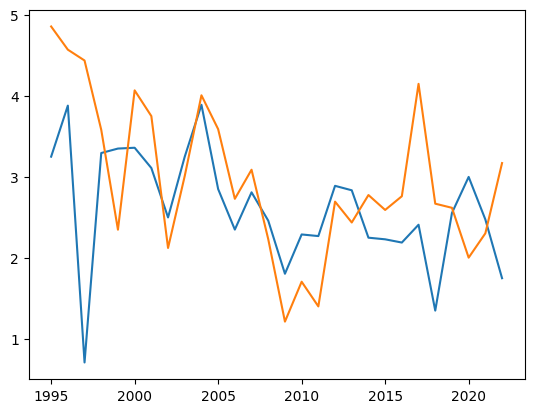

In [ ]:
mins_played["Points_naz_u21"][28:].plot()
mins_played["Minutes_played_italians"][28:].plot()

In [ ]:
from statsmodels.tsa.stattools import ccf

cross_corr_ita_nazu21=ccf(mins_played["Points_naz_u21"][28:-],mins_played["Minutes_played_italians"][28:-1],adjusted=True)
corr_pearson_ita_nazu21=pearsonr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][24:-2],alternative='greater')
print("Cross correlation between Italian U21 players and National Team U21 Points")
print("--------------------------------------------------------------------------------------------")
print(f"Peason Correlation: {round(corr_pearson_ita_nazu21.statistic,4)}, P-value {round(corr_pearson_ita_nazu21.pvalue,4)}")
print(f"Correlation Minutes_played_italians e Points_naz_u21 Lag 0: {round(cross_corr_ita_nazu21[0],4)}")
print(f"Correlation Minutes_played_italians e Points_naz_u21 Lag 1: {round(cross_corr_ita_nazu21[3],4)}")
print(f"Correlation Minutes_played_italians e Points_naz_u21 Lag 2: {round(cross_corr_ita_nazu21[1],4)}")


print("--------------------------------------------------------------------------------------------")

corr_spearman_ita_nazu21=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][24:-2])
corr_spearman_ita_nazu21_lag1=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][23:-2].shift(1).dropna())
corr_spearman_ita_nazu21_lag2=spearmanr(mins_played["Points_naz_u21"][24:-2],mins_played["Minutes_played_italians"][22:-2].shift(2).dropna())


print(f"Spearman Correlation: {round(corr_spearman_ita_nazu21.statistic,4)}, P-value {round(corr_spearman_ita_nazu21.pvalue,4)}")
print(f"Lag1 Correlation: {round(corr_spearman_ita_nazu21_lag1.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag1.pvalue,4)}")
print(f"Lag2 Correlation: {round(corr_spearman_ita_nazu21_lag2.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag2.pvalue,4)}")




Cross correlation between Italian U21 players and National Team U21 Points
--------------------------------------------------------------------------------------------
Peason Correlation: 0.4989, P-value 0.0025
Correlation Minuti giocati Italiani e Punteggio_naz_u21 Lag 0: 0.3255
Correlation Minuti giocati Italiani e Punteggio_naz_u21 Lag 1: 0.4469
Correlation Minuti giocati Italiani e Punteggio_naz_u21 Lag 2: 0.0234
--------------------------------------------------------------------------------------------
Spearman Correlation: 0.566, P-value 0.0011
Lag1 Correlation: 0.4133, P-value 0.0232
Lag2 Correlation: 0.3897, P-value 0.0333


In [ ]:
test_result=grangercausalitytests(mins_played[['Points_naz_u21','Minutes_played_italians']][28:-1],maxlag=5,verbose=False)
#create a dataframe with the results of the granger causality test
test_result_df=pd.DataFrame(columns=['Lag','Test Statistic','P-value'])
for i in range(3,6):
    test_result_df.loc[i-2]=[i-2,test_result[i][0]['ssr_chi2test'][0],test_result[i][0]['ssr_chi2test'][1]]
print("Grenger Causality Test Results for: Points_naz_u21 and Minutes played by Italian U21 players")
print(test_result_df)




Grenger Causality Test Results for: Points_naz_u21 and Minutes played by Italian U21 players
   Lag  Test Statistic   P-value
1  1.0       12.867615  0.004932
2  2.0       13.344389  0.009710
3  3.0       11.957117  0.035380


In [ ]:
from statsmodels.tsa.stattools import ccf

cross_corr=ccf(mins_played["Entrate"][26:-2],mins_played["Minutes_played_under21"][26:-2],adjusted=True)
corr_pearson_ita_fifa=pearsonr(mins_played["Entrate"][26:-2],mins_played["Minutes_played_under21"][26:-2],alternative='greater')
print("Cross correlation between U21 players and Profit")
print("--------------------------------------------------------------------------------------------")
print(f"Peason Correlation: {round(corr_pearson_ita_fifa.statistic,4)}, P-value {round(corr_pearson_ita_fifa.pvalue,4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 0: {round(cross_corr[0],4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 1: {round(cross_corr[1],4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 2: {round(cross_corr[2],4)}")
print("--------------------------------------------------------------------------------------------")

corr_spearman_ita_nazu21=spearmanr(np.log(mins_played["Entrate"][27:-2]),mins_played["Minutes_played_under21"][27:-2])
corr_spearman_ita_nazu21_lag1=spearmanr(np.log(mins_played["Entrate"][27:-2]),mins_played["Minutes_played_under21"][26:-2].shift(1).dropna())
corr_spearman_ita_nazu21_lag2=spearmanr(np.log(mins_played["Entrate"][27:-2]),mins_played["Minutes_played_under21"][25:-2].shift(2).dropna())

print(f"Spearman Correlation: {round(corr_spearman_ita_nazu21.statistic,4)}, P-value {round(corr_spearman_ita_nazu21.pvalue,4)}")
print(f"Lag1 Correlation: {round(corr_spearman_ita_nazu21_lag1.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag1.pvalue,4)}")
print(f"Lag2 Correlation: {round(corr_spearman_ita_nazu21_lag2.statistic,4)}, P-value {round(corr_spearman_ita_nazu21_lag2.pvalue,4)}")

Cross correlation between U21 players and Profit
--------------------------------------------------------------------------------------------
Peason Correlation: 0.3408, P-value 0.038
Correlation Minuti giocati under21 e Entrate Lag 0: 0.3408
Correlation Minuti giocati under21 e Entrate Lag 1: 0.4047
Correlation Minuti giocati under21 e Entrate Lag 2: 0.1883
--------------------------------------------------------------------------------------------
Spearman Correlation: 0.2149, P-value 0.2817
Lag1 Correlation: 0.2405, P-value 0.2268
Lag2 Correlation: 0.0513, P-value 0.7995


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

test_result=grangercausalitytests(mins_played[['revenue','Minutes_played_under21']][28:],maxlag=5,verbose=False)
test_result_df=pd.DataFrame(columns=['Lag','Test Statistic','P-value'])
for i in range(3,6):
    test_result_df.loc[i-1]=[i-1,test_result[i][0]['ssr_chi2test'][0],test_result[i][0]['ssr_chi2test'][1]]
print("Grenger Causality Test Results for: Profit and Minutes played by U21 players")
print(test_result_df)

NameError: name 'mins_played' is not defined

In [53]:
from statsmodels.tsa.stattools import ccf

cross_corr=ccf(mins_played["revenue"][29:],mins_played["Minutes_played_under21"][29:],adjusted=True)
corr_pearson_ita_fifa=pearsonr(mins_played["revenue"][26:],mins_played["Minutes_played_under21"][26:],alternative='two-sided')
print("Cross correlation between U21 players and Profit")
print("--------------------------------------------------------------------------------------------")
print(f"Peason Correlation: {round(corr_pearson_ita_fifa.statistic,4)}, P-value {round(corr_pearson_ita_fifa.pvalue,4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 0: {round(cross_corr[0],4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 1: {round(cross_corr[1],4)}")
print(f"Correlation Minutes_played_under21 e Entrate Lag 2: {round(cross_corr[3],4)}")
print("--------------------------------------------------------------------------------------------")

Cross correlation between U21 players and Profit
--------------------------------------------------------------------------------------------
Peason Correlation: 0.2486, P-value 0.1853
Correlation Minuti giocati under21 e Entrate Lag 0: 0.324
Correlation Minuti giocati under21 e Entrate Lag 1: 0.4178
Correlation Minuti giocati under21 e Entrate Lag 2: 0.1756
--------------------------------------------------------------------------------------------


<Axes: >

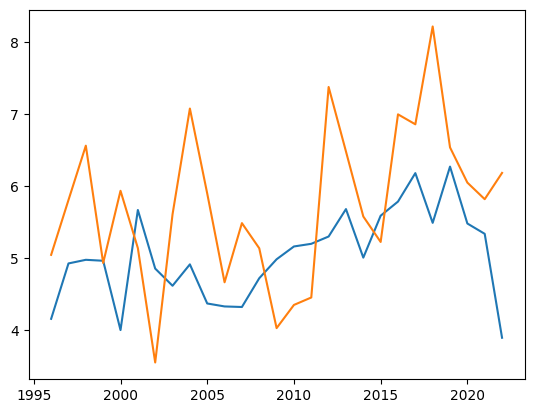

In [56]:
mins_played["revenue"][29:].plot()
mins_played["Minutes_played_under21"][29:].plot()


In [112]:
adf_test(mins_played[["Minutes_played_italians","Points_naz_u21","Punti per partita","revenue"]][29:-1])


,Minuti giocati Italiani,Punteggio_naz_u21,Punti per partita,revenue
Test statistic,-3.1896,-5.3031,-1.7296,-2.8200
p-value,0.0206,0.0000,0.4159,0.0555
Critical value - 1%,-3.7239,-3.7239,-3.8092,-3.9240
Critical value - 5%,-2.9865,-2.9865,-3.0216,-3.0685
Critical value - 10%,-2.6328,-2.6328,-2.6507,-2.6739


In [470]:
kpss(prova["Log"][25:-2],regression='c')

(0.6643508858891736,
 0.01678628310098422,
 3,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

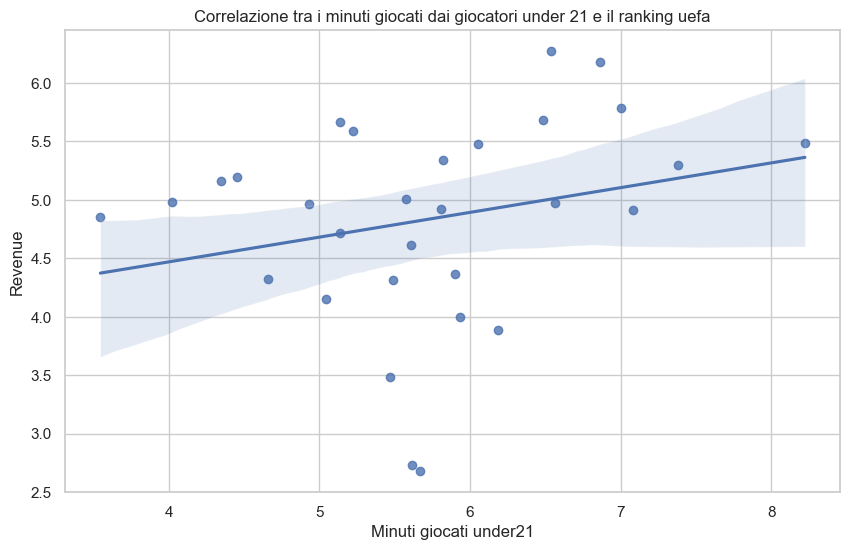

In [57]:
#stampa il grafico della correlazione tra i minuti giocati dai giocatori under 21 e il ranking uefa come retta di regressione
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.regplot(x=mins_played["Minutes_played_under21"], y=mins_played["revenue"])
plt.xlabel("Minutes_played_under21")
plt.ylabel("Revenue")
plt.title("Correlazione tra i minuti giocati dai giocatori under 21 e il ranking uefa")
plt.show()



In [65]:
#fai la OLS regression tra i minuti giocati dai giocatori under 21 e il ranking uefa
import statsmodels.api as sm

X = mins_played["Minutes_played_under21"][29:-1]
y = mins_played["revenue"][29:-1]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4.112
Date:                Tue, 06 Feb 2024   Prob (F-statistic):             0.0538
Time:                        13:38:59   Log-Likelihood:                -20.655
No. Observations:                  26   AIC:                             45.31
Df Residuals:                      24   BIC:                             47.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

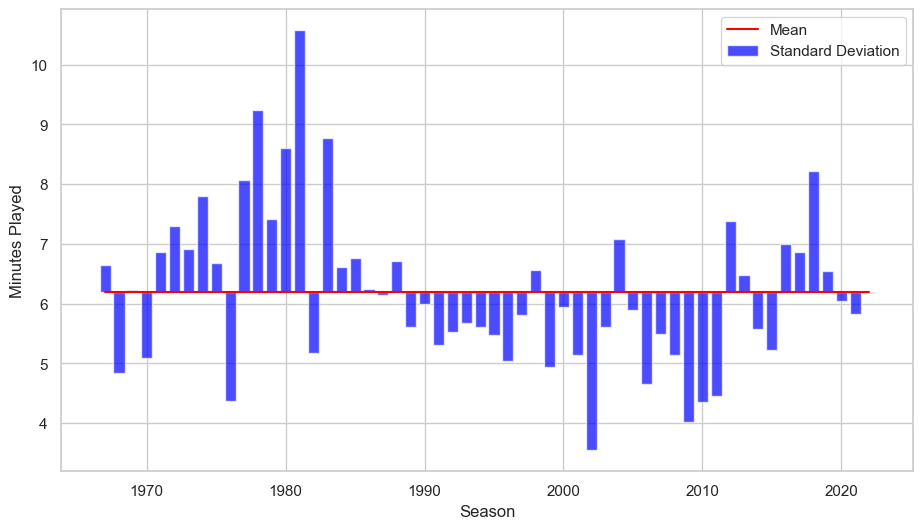

In [66]:
sns.set_style("whitegrid")

# Calcola la media dei minuti giocati
mean_minutes = mins_played['Minutes_played_under21'].mean()

# Calcola la deviazione dei minuti giocati rispetto alla media
mins_played['Deviazione'] = mins_played['Minutes_played_under21'] - mean_minutes
# Plot della linea media
plt.figure(figsize=(11, 6))
plt.plot(mins_played.index, [mean_minutes] * len(mins_played), label='Mean', color='red')

# Plot delle barre di deviazione per ogni stagione
plt.bar(mins_played.index, mins_played['Deviazione'], color='blue', alpha=0.7, label='Standard Deviation',bottom=mean_minutes)

#plt.title('Mean and Standard Deviation of Minutes Played by Under-21 Players')
plt.xlabel('Season')
plt.ylabel('Minutes Played')
plt.legend()
plt.show()

In [68]:
#correlazione tra il la percentuale di minuti giocati dagli under 21 stranieri e italiani nel periodo 2011-2012 e 2021-2022
from scipy.stats import pearsonr,spearmanr

corr_pearson, p_value = pearsonr(mins_played["Minutes_played_italians"][40:],mins_played["Minutes_played_under21"][40:])
correlazione_spearman, p_value_spearman= spearmanr(mins_played["Minutes_played_italians"][40:],mins_played["Minutes_played_under21"][40:])
print(f"Correlazione di Pearson: {corr_pearson}")
print(f"P-value Pearson: {p_value}")
print(f"Correlazione di Spearman: {correlazione_spearman}")
print(f"P-value Spearman: {p_value_spearman}")



Correlazione di Pearson: 0.6322462631729238
P-value Pearson: 0.00859220904418894
Correlazione di Spearman: 0.6235294117647059
P-value Spearman: 0.009855650390922007


In [69]:
#crea un datframe chiamato perc_under_ita_stra
perc_under_ita_stra=mins_played[41:]
#perc_under_ita_stra.head()
perc_under_ita_stra["Minutes_played_foreigners"]=perc_under_ita_stra["Minutes_played_foreigners"]/perc_under_ita_stra["Minutes_played_under21"]*100
perc_under_ita_stra["Minutes_played_italians"]=perc_under_ita_stra["Minutes_played_italians"]/perc_under_ita_stra["Minutes_played_under21"]*100+perc_under_ita_stra["Minutes_played_oriundi"]/perc_under_ita_stra["Minutes_played_under21"]*100
#perc_under_ita_stra["Minutes_played_oriundi"]=perc_under_ita_stra["Minutes_played_oriundi"]/perc_under_ita_stra["Minutes_played_under21"]*100
perc_under_ita_stra=perc_under_ita_stra.drop(columns=["Minutes_played_oriundi"])
#perc_under_ita_stra


In [70]:
#fai la media di ogni tre anni e crea un nuvo datframe
perc_under_ita_stra=perc_under_ita_stra.rolling(3).mean()

In [71]:
print(f"L'influenza percentuale di Minuti_under21_Stranieri sul trend è: {perc_under_ita_stra['Minutes_played_foreigners'].mean()}")
print(f"La deviazione standard di Minuti_under21_Strasnieri sul trend è: {perc_under_ita_stra['Minutes_played_foreigners'].std()}")
#intervallo di confidenza al 95%
confidence_interval_stra = stats.t.interval(0.95, len(perc_under_ita_stra["Minutes_played_foreigners"])-1, loc=perc_under_ita_stra["Minutes_played_foreigners"].mean(), scale=stats.sem(perc_under_ita_stra["Minutes_played_foreigners"]))
print(f"Intervallo di Confidenza Minuti_under21_Strasnieri al 95%: {confidence_interval_stra}")

print(f"L'influenza percentuale di Minuti_under21_Italiani sul trend è: {perc_under_ita_stra['Minutes_played_italians'].mean()}")
print(f"deviazione standard di Minuti_under21_Italiani sul trend è: {perc_under_ita_stra['Minutes_played_italians'].std()}")
#intervallo di confidenza al 95%
confidence_interval_ita = stats.t.interval(0.95, len(perc_under_ita_stra["Minutes_played_italians"])-1, loc=perc_under_ita_stra["Minutes_played_italians"].mean(), scale=stats.sem(perc_under_ita_stra["Minutes_played_italians"]))
print(f"Intervallo di Confidenza Minuti_under21_Italiani al 95%: {confidence_interval_ita}")


L'influenza percentuale di Minuti_under21_Stranieri sul trend è: 59.39138902372803
La deviazione standard di Minuti_under21_Strasnieri sul trend è: 5.155937369465306
Intervallo di Confidenza Minuti_under21_Strasnieri al 95%: (nan, nan)
L'influenza percentuale di Minuti_under21_Italiani sul trend è: 45.24695884037174
deviazione standard di Minuti_under21_Italiani sul trend è: 5.2005675548979475
Intervallo di Confidenza Minuti_under21_Italiani al 95%: (nan, nan)


In [72]:
perc_under_ita_stra.rolling(window=3).mean()[2:]

,Minuti giocati under21,Minuti giocati Italiani,Minuti giocati Stranieri,Uefa_Ranking,FifaPoints,Punti per partita,Punteggio_naz_u21,revenue,Deviazione
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,4.723522,40.784900,64.328507,7.132494,1.482380,1.985556,2.263333,5.096032,-1.477337
2013,5.257487,38.991846,65.134421,7.143772,1.446771,2.090000,2.423333,5.242230,-0.943371
2014,5.992734,42.216913,62.581321,7.848224,1.445799,2.102222,2.602222,5.313849,-0.208124
2015,6.115541,45.051538,59.276783,8.416911,1.402590,2.045556,2.587222,5.382413,-0.085317
2016,6.058539,48.523858,55.583091,8.780909,1.309495,1.912222,2.440000,5.404808,-0.142320
2017,6.018829,50.742791,52.732005,8.468627,1.232054,1.798889,2.312778,5.579216,-0.182030
2018,6.551849,50.523960,53.243742,8.341314,1.195772,1.633333,2.161111,5.710447,0.350990
2019,6.976387,49.905073,53.896031,8.332024,1.164679,1.635556,2.121667,5.884109,0.775528


## Bayesian changepoint detection con Ruptures

In [ ]:
#modify the index of mins_played and get only the first part(examples: 2022-2023 becomes 2022, 2021-2022 becomes 2021)
mins_played.index=mins_played.index.str[:4].astype(int)
#convert the index of mins_played to DateTime
mins_played.index=pd.to_datetime(mins_played.index, format='%Y')

In [ ]:
mins_played.index = mins_played.index.to_period('Y')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(900/96, 250/96), dpi=96)
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minutes_played_under21"].values.reshape(-1, 1)

penalty=2*np.log(len(impressions))*np.std(impressions)**2
print
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Pelt(model=model,jump=1).fit(impressions)
result = algo.predict(pen=7)

# Puoi visualizzare i punti di rottura sul grafico

#rpt.display(impressions,[], result)


# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result[0:-1]])

# Puoi visualizzare i punti di rottura sul grafico
#rpt.display(impressions,[], result)
ax.plot(impressions)
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r', )
ax.set_title("Bayesian changepoint detection with Pelt")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,56))
b=list(range(1967,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(900/96, 250/96), dpi=96)

# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions = mins_played["Minutes_played_under21"].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=3,jump=2).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
#rpt.display(impressions,[], result)
ax.plot(impressions)
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r', )
ax.set_title("Bayesian changepoint detection with Dynp")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,56))
b=list(range(1967,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()


In [ ]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_first_up_trend = (mins_played["Minutes_played_italians"][22:]+mins_played["Minutes_played_oriundi"][22:]).values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=4,jump=5).fit(impressions_first_up_trend)
result = algo.predict(n_bkps=2)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1989 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_first_up_trend,[], result)

In [ ]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_first_up_trend = mins_played["Minutes_played_under21"][0:22].values.reshape(-1, 1)

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=3).fit(impressions_first_up_trend)
result = algo.predict(n_bkps=2)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+1967 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_first_up_trend,[], result)

In [ ]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l2"
impressions_final_trend = mins_played["Minutes_played_under21"][50:].values.reshape(-1, 1)
# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=3).fit(impressions_final_trend)
result = algo.predict(n_bkps=1)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", [x+2002 for x in result])

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions_final_trend,[], result)

In [ ]:
# Crea un punto di rottura con il modello "l1" (changepoint detection basato sulla somma delle differenze)
model = "l1"

# Esegui il rilevamento dei cambiamenti senza specificare il numero di punti di rottura
algo = rpt.Dynp(model=model, min_size=1,jump=1).fit(impressions)
result = algo.predict(n_bkps=3)

# Stampa i punti di rottura trovati
print("Punti di rottura trovati:", result)

# Puoi visualizzare i punti di rottura sul grafico
rpt.display(impressions,[], result)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=3)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='k', linestyle='--')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,54))
b=list(range(1969,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(800/96, 500/96), dpi=96)

kernel = 'linear'
algo = rpt.KernelCPD(kernel=kernel, min_size=6)
algo.fit(impressions)
result = algo.predict(n_bkps=1)
ax.plot(impressions,marker='o')
for bkp in result[0:-1]:
    ax.axvline(x=bkp, color='r')
ax.set_title("Bayesian changepoint detection with Ruptures")
fig.tight_layout()
#change the x ticks to be the index of mins_played
#crea una lista da 0 a 54
a=list(range(0,33))
b=list(range(1990,2023))
ax.set_xticks(a,b)
#ruota i tick di 90 gradi
plt.xticks(rotation=90)
print("Punti di rottura trovati:", result[0:-1])
plt.show()



## Test Mann-Kendall

### Test Mann-Kendall under-21 2011/2012 to 2022/2023

In [ ]:
mean_value = np.mean(mins_played["Minutes_played_under21"][45:])
print(f"Mean: {mean_value}")

# Calcola la varianza
variance_value = np.var(mins_played["Minutes_played_under21"][45:])
print(f"Variance: {variance_value}")

# Calcola l'intervallo di confidenza al 95%
confidence_interval = stats.t.interval(0.95, len(mins_played["Minutes_played_under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minutes_played_under21"][45:]))
confidence_interval_90 = stats.t.interval(0.90, len(mins_played["Minutes_played_under21"][45:])-1, loc=mean_value, scale=stats.sem(mins_played["Minutes_played_under21"][45:]))

print(f"Confidence Interval 95%: {confidence_interval}")
print(f"Intervallo di Confidenza al 90%: {confidence_interval_90}")

### Test Mann-Kendall under-21 1973/1974 to 1984/1985

In [ ]:
data = (mins_played["Minutes_played_italians"][24:37] + mins_played["Minutes_played_oriundi"][24:37])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.original_test(data,alpha=0.075)

print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data[1:])
ax.plot(data[1:].index, trend_line[1:])
ax.legend(['data', 'trend line'])

### Test Mann-Kendall under-21 1985/1986 to 2011/2012

In [ ]:
data = (mins_played["Minutes_played_under21"][25:46])
data_bis = (mins_played["Minutes_played_under21"][22:45])


fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data[:-1])
ax.plot(data[:-1].index, trend_line[:-1])
ax.legend(['data', 'trend line'])

### Test Mann-kendall e stazioniarietà ADCF 1992/1993 to 2011/2012

In [ ]:
data = (mins_played["Minutes_played_under21"][39:60])

fig, ax = plt.subplots(figsize=(12, 8))
res = mk.hamed_rao_modification_test(data)
print(res)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

In [ ]:
#fai il modello ARIMA

from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model

model = ARIMA(mins_played["Minutes_played_under21"][22:45], order=(2,3,5))
#add costant to the model

model_fit = model.fit()
# make prediction
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())



In [ ]:
#plot the forecast of the model
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.arima.model import ARIMA
from random import random
# fit model
model = ARIMA(mins_played["Minutes_played_under21"][:-3], order=(2,3,5))
model_fit = model.fit()
print(model_fit.summary())

# forecast
#yhat = model_fit.predict(1, 54)
#plt.plot(yhat)
#plt.plot(mins_played["Minutes_played_under21"])
#plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mins_played["Minutes_played_under21"], lags=50)
plt.show()

In [ ]:
#usa il modello AR AutoRegression
from statsmodels.tsa.ar_model import AutoReg
from random import random
# fit model
model = AutoReg(mins_played["Minutes_played_under21"],mins_played["Uefa_ranking"], lags=3)
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
#fai la regressioe OLS condiderando anche i residui
# Fit a linear regression model (you can replace this with your specific model)
model = sm.OLS((mins_played['Minutes_played_italians'][39:]+mins_played['Minutes_played_oriundi'][39:]), np.arange(len(mins_played['Minutes_played_italians'][39:]))).fit()
model21= sm.OLS(mins_played['Minutes_played_under21'][39:], np.arange(len(mins_played['Minutes_played_under21'][39:]))).fit()
print(model.summary())